Making a comparison between the matter-flux relationship measured in COSMOS vs in Nyx100. For now using CLAMATO2017 data.

The approach is to load the CLAMATO map in [RA, Dec, redshift], translate to the coordinate system of the BIRTH reconstructions, and then sample the BIRTH densities at the CLAMATO voxels.

For initial comparison, Metin has found that realization #2470 has the best match to the COSMOS data.

In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import integrate

# Cosmological parameters
OM = 0.31
OL = 1.-OM
OC = 1.-OM-OL
H = 100.
c = 299792./H
h = .7

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=OM)

#define 2D roation
def rotatez(x,y,alpha):
    xnew = x * np.cos(alpha) - y* np.sin(alpha)
    ynew = x * np.sin(alpha) + y * np.cos(alpha)
    return (xnew,ynew)
rotatez_vec = np.vectorize(rotatez)

def rotatey(x,z,alpha):
    xnew = x * np.cos(alpha) + z* np.sin(alpha)
    znew = -1.* x * np.sin(alpha) + z * np.cos(alpha)
    return (xnew,znew)
rotatey_vec = np.vectorize(rotatey)

# Corresponding code is from Metin
#redshift to distance
########################
#Functions
def E(z):
  return 1./np.sqrt(OM*(1+z)**3 +OL)

def dist_single(lim):
  return c*integrate.quad(E, 0., lim)[0]

dist = np.vectorize(dist_single)


Read in CLAMATO data, and plot a slice as sanity check. x=0 should yield the bottom slice (lowest RA) of Fig 9b in Lee+2018.

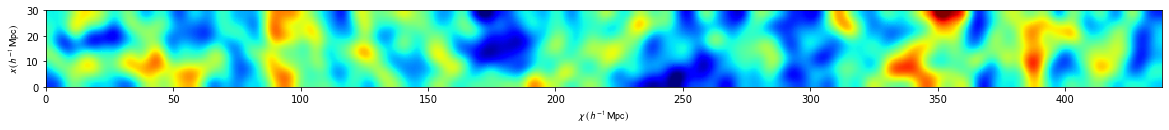

In [2]:
TomoFil = '/Users/kheegan/lya/3d_recon/map2017/map_2017_v4.bin'
TomoFlatArr = np.fromfile(TomoFil, dtype=np.float64)
flux = TomoFlatArr.reshape(60, 48, 876)
dx_f = 0.5 #Mpc/h
rsm_test = 2. # Fig 9 in Lee+2018 was smoothed by 2Mpc/h gaussian
rsm = 3.
rsm_eff = np.sqrt(rsm**2 - dx_f**2)  # this is the smoothing we want for the analysis
fluxsmtest = ndimage.gaussian_filter(flux, rsm_test/dx_f) 
fluxsm = ndimage.gaussian_filter(flux, rsm_eff/dx_f)  

ra_slice = fluxsm[:, 10, :]

ybins = np.linspace(0., 30., 61)
zbins = np.linspace(0., 438., 877)

Y, Z = np.meshgrid(ybins, zbins)

fig, ax = plt.subplots(figsize=(20., 3.))

ax.pcolormesh(Z, Y, ra_slice.T, cmap='jet_r', vmin=-0.3, vmax=0.2)
ax.set_aspect('equal')
ax.set_xlabel(r'$\chi\;(h^{-1}\,\mathrm{Mpc})$')
ax.set_ylabel(r'$x\;(h^{-1}\,\mathrm{Mpc})$')
plt.show()

Set up the coordinate system for the tomographic map [RA, Dec, z], and convert to the comoving coordinates of Metin's reconstructions.

In [3]:
# These are the vertices of the CLAMATO2017 map on the sky, in degrees
ra_min = 149.95000
ra_max = 150.39359
dec_min = 2.1500001
dec_max = 2.5048765

# The redshift origin was fixed at z=2.05, while the dcomdis/dz was fixed based the fiducial cosmology
red0 = 2.05
dcomdisdz = 871.627  # Mpc/h

d_dec = (dec_max - dec_min)/48.
d_ra = (ra_max - ra_min)/60.
ravec = np.linspace(ra_min, ra_max, 60, endpoint=False) + d_ra/2.
decvec = np.linspace(dec_min, dec_max, 48, endpoint=False) + d_dec/2.
redvec = red0 + (np.linspace(0., 438., 876, endpoint=False)+0.25)/dcomdisdz

RA, Dec, Red = np.meshgrid(ravec, decvec, redvec,indexing='ij')

# Convert [RA, Dec, redshift] to comoving distances in the same frame as the BIRTH reconstructions

#if your data is in degrees in ra,dec,redshift
distances = dist(Red)
x = distances*np.cos(np.radians(RA))*np.cos(np.radians(Dec))
y = distances*np.sin(np.radians(RA))*np.cos(np.radians(Dec))
z = distances*np.sin(np.radians(Dec))

alphaz = 0.5222498240693092
alphay = -0.038223252377631946

xnew, ynew = rotatez_vec(x,y,alphaz)
xnew, znew = rotatey_vec(xnew,z,alphay)


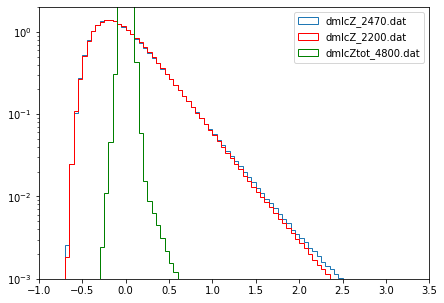

In [4]:
Lbirth = 480.
ncell = 256
dxb = Lbirth/ncell

# This gaussian smoothing scale is 1.2x the 3Mpc/h fiducial applied to Nyx, which we artificially boosted
# to make the density PDFs match
gauss_sm = 3.6  


filedir = '/Users/kheegan/lya/3d_recon/preheating/'
dmdata = 'dmlcZ_2470.dat'
dm_in = np.fromfile(filedir+dmdata, dtype=np.float32)
npix1d_dm = np.rint(np.cbrt(len(dm_in))).astype(np.int)
# Reshape the boxes
dm = dm_in.reshape((npix1d_dm, npix1d_dm, npix1d_dm))
dmsm = ndimage.gaussian_filter(dm, gauss_sm/dxb)

dmdata2 = 'dmlcZ_2200.dat'
dm_in2 = np.fromfile(filedir+dmdata2, dtype=np.float32)
# Reshape the boxes
dm2 = dm_in2.reshape((npix1d_dm, npix1d_dm, npix1d_dm))
dmsm2 = ndimage.gaussian_filter(dm2, gauss_sm/dxb)

dmdata3 = 'dmlcZtot_4800.dat'
dm_in3 = np.fromfile(filedir+dmdata3, dtype=np.float32)
# Reshape the boxes
dmsm3 = dm_in3.reshape((npix1d_dm, npix1d_dm, npix1d_dm))
#dmsm3 = ndimage.gaussian_filter(dm3, 3.6)

fig, ax = plt.subplots(figsize=(7,5))

ax.hist(dmsm.flatten(), bins=np.arange(-1.,5.,0.05), density=True, log=True, label=dmdata,
       histtype='step')
ax.hist(dmsm2.flatten(), bins=np.arange(-1.,5.,0.05), density=True, log=True, label=dmdata2,
       histtype='step', color='red')
ax.hist(dmsm3.flatten(), bins=np.arange(-1.,5.,0.05), density=True, log=True, label=dmdata3,
       histtype='step', color='green')
ax.set_ylim(1e-3, 2.)
ax.set_xlim(-1, 3.5)
ax.legend()

plt.show()

In [5]:
# These are the zero points for the BIRTH lightcone
x0 = -4080.
y0 = -240.
z0 = -240.

# These is the translation of the comoving coordinates to array indices
ix = (xnew-x0)/dxb - dxb/2.
iy = (ynew-y0)/dxb - dxb/2.
iz = (znew-z0)/dxb - dxb/2.

i3d_arr = np.asarray([ix.flatten(), iy.flatten(), iz.flatten()])

dm_int = ndimage.map_coordinates(dmsm, i3d_arr, order=1, mode='constant').reshape(60,48,876)
dm_int2 = ndimage.map_coordinates(dmsm2, i3d_arr, order=1, mode='constant').reshape(60,48,876)
dm_int3 = ndimage.map_coordinates(dmsm3, i3d_arr, order=1, mode='constant').reshape(60,48,876)


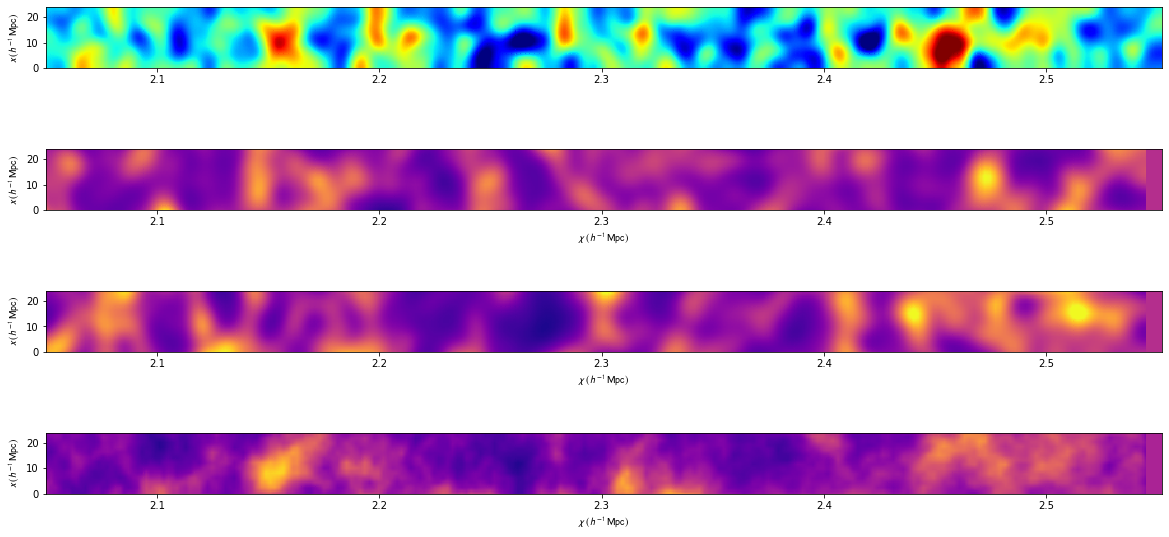

In [11]:
fig, (ax, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(20., 10.))

islice = 59

flux_slice = fluxsm[islice,:, :]
dm_slice = dm_int[islice,:,:]
dm_slice2 = dm_int2[islice,:,:]
dm_slice3 = dm_int3[islice,:,:]

ybins = np.linspace(0., 24., 49)
zbins = np.linspace(2.05, 2.552, 877)

AspectRatio= 1./dcomdisdz

Y, Z = np.meshgrid(ybins, zbins)

ax.pcolormesh(Z, Y, flux_slice.T, cmap='jet_r', vmin=-0.3, vmax=0.2)
ax.set_aspect(AspectRatio)
ax.set_ylabel(r'$x\;(h^{-1}\,\mathrm{Mpc})$')


ax2.pcolormesh(Z, Y, dm_slice.T, cmap='plasma', vmin=-0.7, vmax=1.)
ax2.set_ylabel(r'$x\;(h^{-1}\,\mathrm{Mpc})$')
ax2.set_xlabel(r'$\chi\;(h^{-1}\,\mathrm{Mpc})$')
ax2.set_aspect(AspectRatio)

ax3.pcolormesh(Z, Y, dm_slice2.T, cmap='plasma', vmin=-0.7, vmax=1.)
ax3.set_ylabel(r'$x\;(h^{-1}\,\mathrm{Mpc})$')
ax3.set_xlabel(r'$\chi\;(h^{-1}\,\mathrm{Mpc})$')
ax3.set_aspect(AspectRatio)

ax4.pcolormesh(Z, Y, dm_slice3.T, cmap='plasma', vmin=-0.3, vmax=0.5)
ax4.set_ylabel(r'$x\;(h^{-1}\,\mathrm{Mpc})$')
ax4.set_xlabel(r'$\chi\;(h^{-1}\,\mathrm{Mpc})$')
ax4.set_aspect(AspectRatio)

plt.show()

In [12]:
# compute and plot 2d histogram
bins_f = np.arange(-0.35,0.3, 0.01)
bins_dm = np.arange(0., 4., 0.05)

hist2d, edges_dm, edges_f = np.histogram2d(dm_int2.flatten()+1., fluxsm.flatten(), 
                                           bins=[bins_dm, bins_f],density=True)             

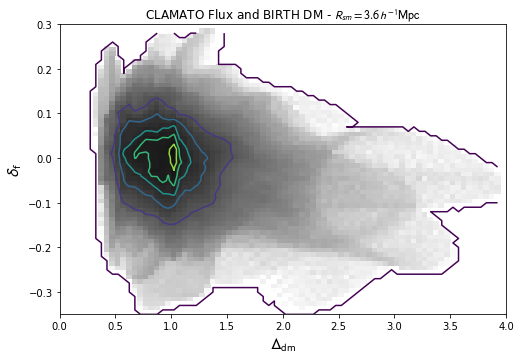

In [13]:
X, Y = np.meshgrid(edges_dm,  edges_f)
XCon, YCon = np.meshgrid(edges_dm[0:-1]+(edges_dm[1]-edges_dm[0])/2 , 
                         edges_f[0:-1]+(edges_f[1]-edges_f[1])/2 )

fig, ax = plt.subplots(figsize=(8,7))

ax.pcolormesh(X,Y, np.transpose(hist2d), cmap='Greys',
              norm=matplotlib.colors.LogNorm(vmin=2e-3, vmax=15.))

ax.set_xlim(0., 4.)
ax.set_ylim(-0.35,0.3)
ax.set_xlabel(r'$\Delta_\mathrm{dm}$', fontsize=16)
ax.set_ylabel(r'$\delta_\mathrm{f}$', fontsize=16)
ax.set_aspect(4.)
smtext = r'$R_{sm} = '+'{}'.format(gauss_sm)+'\, h^{-1}\mathrm{Mpc}$'
ax.set_title('CLAMATO Flux and BIRTH DM - '+smtext)

ax.contour(XCon,YCon, np.transpose(hist2d))

plt.show()

In [9]:
from scipy.stats import pearsonr

print(pearsonr(np.ndarray.flatten(dm_int2), np.ndarray.flatten(fluxsm)))

(-0.20916019242058398, 0.0)


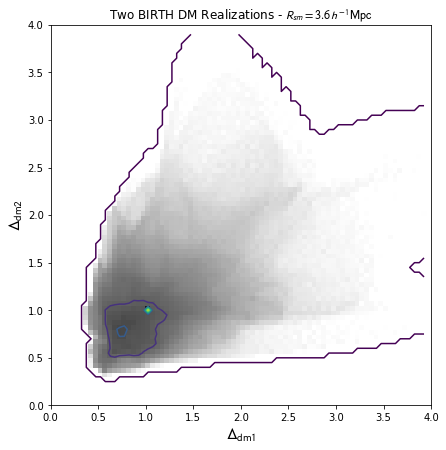

(0.42689383, 0.0)


In [10]:
# Plot delta_dm-delta_dm distribution
hist2d, edges_dm1, edges_dm2 = np.histogram2d(dm_int.flatten()+1., dm_int2.flatten()+1, 
                                           bins=[bins_dm, bins_dm],density=True)  

X, Y = np.meshgrid(edges_dm,  edges_dm)
XCon, YCon = np.meshgrid(edges_dm[0:-1]+(edges_dm[1]-edges_dm[0])/2 , 
                         edges_dm2[0:-1]+(edges_dm2[1]-edges_dm2[1])/2 )

fig, ax = plt.subplots(figsize=(8,7))

ax.pcolormesh(X,Y, np.transpose(hist2d), cmap='Greys',
              norm=matplotlib.colors.LogNorm(vmin=2e-3, vmax=15.))

ax.set_xlim(0., 4.)
ax.set_ylim(0,4.)
ax.set_xlabel(r'$\Delta_\mathrm{dm1}$', fontsize=16)
ax.set_ylabel(r'$\Delta_\mathrm{dm2}$', fontsize=16)
ax.set_aspect('equal')
smtext = r'$R_{sm} = '+'{}'.format(gauss_sm)+'\, h^{-1}\mathrm{Mpc}$'
ax.set_title('Two BIRTH DM Realizations - '+smtext)

ax.contour(XCon,YCon, np.transpose(hist2d))

plt.show()

print(pearsonr(np.ndarray.flatten(dm_int), np.ndarray.flatten(dm_int2)))